## Classical Cunterfeit Coin Problem

In the classical world this problem is solved by <b>decrease(-by-half)-and-conquer</b> approach <br> Suppose we divide the coins into three piles, where at least two of them contain the same number of coins. After weighing the equal-sized piles, we can eliminate ~2/3 of the coins!

To design an algorithm, we need to be more precise.
<ul>
    <li>If n mod 3 = 0, we can divide the coins into three piles of exactly n/3 apiece.</li>

<li>If n mod 3 = 1, then n = 3k + 1 for some k. We can divide the coins into three piles of k, k, and k+1. It will simplify our algorithm, though, if we split them into three piles of k+1, k+1, and k-1.</li>

<li>If n mod 3 = 2, then n = 3k + 2 for some k. We can divide the coins into three piles of k+1, k+1, and k.</li>
    </ul>

## Pseudocode of the approach in the classical world

Take an input integer number: n

if n==1 then return n

else <br>
&nbsp;&nbsp;&nbsp;&nbsp;       divide the coins into piles of A = ceiling(n/3), B = ceiling(n/3) and C = n-2*ceiling(n/3) <br>
&nbsp;&nbsp;&nbsp;&nbsp;       weigh A and B <br>
&nbsp;&nbsp;&nbsp;&nbsp;       if the scale balances then iterate with C <br>
&nbsp;&nbsp;&nbsp;&nbsp;       else <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;          iterate with the lighter of A and B


## Complexity
The complexity of this algorithm is <b>log3 n</b>

## Counterfeit Coin Problem with 12 Coins


You are given two pan fair balance. You have 12 identically looking coins out of which one coin may be lighter or heavier. How can you find odd coin, if any, in minimum trials, also determine whether defective coin is lighter or heavier, in the worst case?

Let us name the coins as 1, 2, … 8, A, B, C and D. We can combine the coins into 3 groups, namely (1234), (5678) and (ABCD). Weigh (1234) and (5678).

<ul>
    <li>(1234) = (5678), both groups are equal. Defective coin may be in (ABCD) group.</li>
    <li>(1234) < (5678), i.e. first group is less in weight than second group.</li>
    <li>(1234) > (5678), i.e. first group is more in weight than second group.</li>
    </ul>
The output (1) can be solved in two more weighing. We know that groups (1234) and (5678) are genuine and defective coin may be in (ABCD). Pick one genuine coin from any of weighed groups, and proceed with (ABCD) as explained in Problem 3.

Outcomes (2) and (3) are special. In both the cases, we know that (ABCD) is genuine. And also, we know a set of coins being lighter and a set of coins being heavier. We need to shuffle the weighed two groups in such a way that we end up with smaller height decision tree.

Consider the second outcome where (1234) < (5678). It is possible when any coin among (1, 2, 3, 4) is lighter or any coin among (5, 6, 7, 8 ) is heavier. We revealed lighter or heavier possibility after first weighing. Let us shuffle coins as (1235) and (4BCD) as new groups (there are different shuffles possible, they also lead to minimum weighing). If we weigh these two groups again the outcome can be three ways, 

i) (1235) < (4BCD) yielding one among 1, 2, 3 is lighter, we need one more weighing, <br>
ii) (1235) = (4BCD) yielding one among 6, 7, 8 is heavier, we need one more weighing <br>
iii) (1235) > (4BCD) yielding either 5 as heavier coin or 4 as lighter coin, at the expense of one more weighing.
<br><br>
Similar way we can also solve the third outcome where (1234) > (5678) in two more weighing.

We are able to solve the 12 coin puzzle in 3 weighing in the worst case.

## Classical vs Quantum Approach

We have discussed the classical solution above and we will discuss the quantum solution below and before that I want to draw the parallels between the two approaches and will discuss why the qunatum solution is better. <br>
We all know quantum solutions for the problems will be faster than the classical solutions and this case holds true in this problem as well.
<ul>
<li><h3>Classical Approach</h3>
    We have seen in the above solution as well that the classical algorithm requires at least <b>Omega(log{N})</b> uses of the beam balance. </li>
<li><h3>Quantum Approach</h3>
    For the quantum side there exists a solution that can find the counterfeit coin by using the balance only <b>once</b> irrespective of the number of coins given.</li></ul>
<br>
In general, for a given <b>k</b> counterfeit coins of the same weight (but different from the majority of normal coins), that queries the quantum beam balance for <b>O(k^{1/4})</b> in contrast to any classical algorithm that requires <b>Omega(k*log{(N/k)})</b> queries to the beam balance.

## Quantum Algorithm
We have discussed the classical algorithm thoroughly now its time to discuss about the quantum algorithm and how the quantum algorithm is fast and solve this problem with less complexity as compared to the classical algorithm. Before diving in to the countefeit coin algorithm in the quantum world let us first discuss about the <b> Query Modeling</b> in the quantum world and <b>Single Quantum Querying of the database</b>

## Query Modeling
The main motivation of query modeling is that It encompasses many quantum algorithms and it has provable lower bounds. In more detail the deterministic algorithm can be shown as a decision tree with the root x1 and its child nodes as x2 and based on the computation decision one of the path is taken and hence forth as shown in the below figure. ![image](decision_tree.png)  Now the complexity is the number of queries taken to find out the output. The quantum model is a bit more complex then this because in the quantum model we dont percieve this as a tree but rather as a network because in tree there is only one way of communication. So far a quantum model assume a quantum state which is a unit vector because mathematically all the quantum states are the unit vector and the basis states are |1\,|2\,...|n\ . The general state is shown in the figure below ![image](general_state.png)

## Single Quantum Querying of Database
Along with the factorization which is polynomial on the quantum computer, the database lookup have also been provably faster on the quantum computer. This is the application of Bernstein and Vazirani parity problem. <br>
Information theory is a useful tool for analyzing the efficiency of classical algorithms. Problems involving information retrieval from a database are particularly amenable to such analysis. Consider this database search problem: 
we have a database <b>Y</b> that contains n items, of which a single one is marked. This database is represented as a bit string y of length n with Hamming weight one (y has exactly one '1'). One would like to locate the marked item in as few queries to the database as possible. The queries are bit strings x of length n such that
the database returns the answer <br> 
![image](img.png)


where xi and yi are the ith bits of x and y. A simple version of this problem is the case in which the allowed queries x have Hamming weight 1. The information retrieved by a single query xj = δij is small-it adds or eliminates item i from the set of possible marked items. It thus takes n-1 queries to locate the marked item in the worst case. A surprising result of Grover is that a quantum mechanical algorithm can be faster than this and find the marked item with high probability in O(√n) quantum queries, contrary to one's classical intuition. Grover's algorithm does not, however, violate the information theoretic lower bound on the minimal number of queries M. <br>
A quantum algorithm employs a database which responds to superpositions of queries with superpositions of answers. The quantum database acts on two input registers: register X containing the query state |x\ and register B, an output register of dimension A initially containing state |b\ . We define the operation of querying the database as <br><br>
Ry: |x, b\ → |x,[b+a(x, y)] mod A\ <br><br>
where
Ry is a classical reversible transformation which maps basis states to basis states <br>
a(x, y) is the answer to query x, given database state y. In a classical query only query basis states |x\ are used and the output register B is initially set to |0\. However
a quantum database is not restricted to working only on basis states but can handle arbitrary superpositions of inputs. Because of this the information that is retrieved by a single quantum query is not bounded by log2 A. The relevant quantity in the quantum setting is the accessible information in the registers X and B (together called XB) and the internal state of the quantum computer Φ about the database Y. <br>
In the classical world if we want to compute a function such that f(x1,x2,x3,....,xn) then the input variable 'i' will be accessed via xi queries and the complexity of this function is <b>the number of queries</b>. Similarly peridoic finding is one another aspect of it which is done in O(log logN) in quantum world but classicaly requres O(√n). The following image gives us a better understanding of how the quantum query works. ![image](quantum_query.png)


## Quantum Counterfeit Coin Problem

## Problem Description

The Counterfeit Coin Problem is a classical puzzle. It has a long history of challenging one’s reasoning power and ingenuity. The problem goes like this: A man has 8 nickels among which there may be a counterfeit coin, which can only be told apart by its weight being different from the others. How can one tell in not more than three weighing whether there is a counterfeit nickel, if so which one it is and whether it is heavier or lighter than a genuine nickel? The balance we are allowed to use only gives the information whether two masses have the same weight or if not which one is heavier of lighter.


### Preparing the environment
First, we prepare the environment. 

In [1]:
# importing all the helpful libraries 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi, cos, acos, sqrt
from qiskit import Aer, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.tools.visualization import plot_histogram

### Setting up the number of coins

Next, we set the number of coins. This determines the quantum superpositions used by the algorithm.

In [2]:
M = 16                   # Maximum number of qubits available
totalCoins = 8        # This number should be up to M-1

if totalCoins < 4 or totalCoins >= M:
    raise Exception("Please use totalCoins between 4 and ", M-1)

### Setting up the index of the false coin

Next, we set the index of the counterfeit coin. This determines the quantum beam balance.

In [3]:
counterfeitCoinIndex = 5     # This should be 0, 1, ..., totalCoins - 1, where we use Python indexing 

if counterfeitCoinIndex < 0 or counterfeitCoinIndex >= totalCoins:
    raise Exception("counterfeitCoinIndex must be between 0 and ", totalCoins-1)

# Querying the quantum beam balance

As in a classical algorithm to find the counterfeit coin, we will use the balance by placing the same number of coins on the left and right pans of the beam. The difference is that in a quantum algorithm, we can query the beam balance in superposition. To query the quantum beam balance, we use a binary query string to encode coins placed on the pans; namely, the binary string `01101010` means to place coins whose indices are 1, 2, 4, and 6 on the pans, while the binary string `01111011` means to place all coins but those with indices 0 and 4 on the pans. Notice that we do not care how the selected coins are placed on the left and right pans, because their results are the same: it is balanced when no false coin is included, and tilted otherwise. 

In our example, because the number of coins is $8$ and the index of false coin is $5$, the query `01101010` will result in balanced (or, $0$), while the query `01110111` will result in tilted (or, $1$). Using two quantum registers to query the quantum balance, where the first register is for the query string and the second register for the result of the quantum balance, we can write the query to the quantum balance (omitting the normalization of the amplitudes): 

\begin{eqnarray}
|01101010\rangle\Big( |0\rangle - |1\rangle \Big) &\xrightarrow{\mbox{Quantum Beam Balance}}& |01101010\rangle\Big( |0\oplus 0\rangle - |1 \oplus 0\rangle \Big) = |01101010\rangle\Big( |0\rangle - |1\rangle \Big)\\
|01110111\rangle\Big( |0\rangle - |1\rangle \Big) &\xrightarrow{\mbox{Quantum Beam Balance}}& |01110111\rangle\Big( |0 \oplus 1\rangle - |1 \oplus 1\rangle \Big) = (-1) |01110111\rangle\Big( |0 \rangle - |1 \rangle \Big)
\end{eqnarray}

Notice that in the above equation, the phase is flipped if and only if the binary query string is $1$ at the index of the false coin. Let $x \in \left\{0,1\right\}^N$ be the $N$-bit query string (that contains even number of $1$s), and let $e_k \in \left\{0,1\right\}^N$ be the binary string which is $1$ at the index of the false coin and $0$ otherwise. Clearly, 

$$
|x\rangle\Big(|0\rangle - |1\rangle \Big) \xrightarrow{\mbox{Quantum Beam Balance}} \left(-1\right) ^{x\cdot e_k} |x\rangle\Big(|0\rangle - |1\rangle \Big), 
$$
where $x\cdot e_k$ denotes the inner product of $x$ and $e_k$. 

Here, we will prepare the superposition of all binary query strings with even number of $1$s. Namely, we want a circuit that produces the following transformation:

$$
|0\rangle \rightarrow \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle,
$$

where $|x|$ denotes the Hamming weight of $x$.

To obtain such superposition of states of even number of $1$s, we can perform Hadamard transformation on $|0\rangle$ to obtain superposition of $\sum_{x\in\left\{0,1\right\}^N} |x\rangle$, and check if the Hamming weight of $x$ is even. It can be shown that the Hamming weight of $x$ is even if and only if $x_1 \oplus x_2 \oplus \ldots \oplus x_N = 0$. Thus, we can transform:

\begin{equation}
|0\rangle|0\rangle \xrightarrow{H^{\oplus N}} \frac{1}{2^{N/2}}\sum_x |x\rangle |0\rangle \xrightarrow{\mbox{XOR}(x)} \frac{1}{2^{N/2}}\sum_x |x\rangle |0\oplus x_1 \oplus x_2 \oplus \ldots \oplus x_N\rangle 
\end{equation}

The right-hand side of the equation can be divided based on the result of the $\mbox{XOR}(x) = x_1 \oplus \ldots \oplus x_N$, namely, 

$$
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle|0\rangle + \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 1 \mod 2} |x\rangle|1\rangle.
$$

Thus, if we measure the second register and observe $|0\rangle$, the first register is the superposition of all binary query strings we want. If we fail (observe $|1\rangle$), we repeat the above procedure until we observe $|0\rangle$. Each repetition is guaranteed to succeed with probability exactly half. Hence, after several repetitions we should be able to obtain the desired superposition state. 

In [4]:
# Creating registers
# totalCoins qubits for the binary query string and 1 qubit for working and recording the result of quantum balance
qr = QuantumRegister(totalCoins+1)
# for recording the measurement on qr
cr = ClassicalRegister(totalCoins+1)

circuitName = "Counterfeit Coin Problem"
counterfeitCoinCircuit = QuantumCircuit(qr, cr)
N = totalCoins
# Create uniform superposition of all strings of length N
for i in range(N):
    counterfeitCoinCircuit.h(qr[i])

# Perform XOR(x) by applying CNOT gates sequentially from qr[0] to qr[N-1] and storing the result to qr[N]
for i in range(N):
    counterfeitCoinCircuit.cx(qr[i], qr[N])

# Measure qr[N] and store the result to cr[N]. We continue if cr[N] is zero, or repeat otherwise
counterfeitCoinCircuit.measure(qr[N], cr[N])

# we proceed to query the quantum beam balance if the value of cr[0]...cr[N] is all zero
# by preparing the Hadamard state of |1>, i.e., |0> - |1> at qr[N]
counterfeitCoinCircuit.x(qr[N]).c_if(cr, 0)
counterfeitCoinCircuit.h(qr[N]).c_if(cr, 0)

# we rewind the computation when cr[N] is not zero
for i in range(N):
    counterfeitCoinCircuit.h(qr[i]).c_if(cr, 2**N)


# Constructing the quantum beam balance

The quantum beam balance returns $1$ when the binary query string contains the position of the false coin and $0$ otherwise, provided that the Hamming weight of the binary query string is even. Notice that previously, we constructed the superposition of all binary query strings whose Hamming weights are even. Let $k$ be the position of the false coin, then with regards to the binary query string $|x_1,x_2,\ldots,x_N\rangle|0\rangle$, the quantum beam balance simply returns $|x_1,x_2,\ldots,x_N\rangle|0\oplus x_k\rangle$, that can be realized by a CNOT gate with $x_k$ as control and the second register as target. Namely, the quantum beam balance realizes

$$
|x_1,x_2,\ldots,x_N\rangle\Big(|0\rangle - |1\rangle\Big) \xrightarrow{\mbox{Quantum Beam Balance}} |x_1,x_2,\ldots,x_N\rangle\Big(|0\oplus x_k\rangle - |1 \oplus x_k\rangle\Big) = \left(-1\right)^{x\cdot e_k} |x_1,x_2,\ldots,x_N\rangle\Big(|0\rangle - |1\rangle\Big)
$$

Below we apply the quantum beam balance on the desired superposition state. 

In [5]:
k = counterfeitCoinIndex
# Apply the quantum beam balance on the desired superposition state (marked by cr equal to zero)
counterfeitCoinCircuit.cx(qr[k], qr[N]).c_if(cr, 0)

### Identifying the false coin

In the above, we have queried the quantum beam balance once. How to identify the false coin after querying the balance? We simply perform a Hadamard transformation on the binary query string to identify the false coin. Notice that, under the assumption that we query the quantum beam balance with binary strings of even Hamming weight, the following equations hold.

\begin{eqnarray}
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} |x\rangle &\xrightarrow{\mbox{Quantum Beam Balance}}& \frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} \left(-1\right)^{x\cdot e_k} |x\rangle\\
\frac{1}{2^{(N-1)/2}}\sum_{x\in \left\{0,1\right\}^N~\mbox{and}~|x|\equiv 0 \mod 2} \left(-1\right)^{x\cdot e_k} |x\rangle&\xrightarrow{H^{\otimes N}}&  \frac{1}{\sqrt{2}}\Big(|e_k\rangle+|\hat{e_k}\rangle\Big)
\end{eqnarray}

In the above, $e_k$ is the bitstring that is $1$ only at the position of the false coin, and $\hat{e_k}$ is its inverse. Thus, by performing the measurement in the computational basis after the Hadamard transform, we should be able to identify the false coin because it is the one whose label is different from the majority: when $e_k$, the false coin is labelled $1$, and when $\hat{e_k}$ the false coin is labelled $0$. 

In [6]:
# Apply Hadamard transform on qr[0] ... qr[N-1]
for i in range(N):
    counterfeitCoinCircuit.h(qr[i]).c_if(cr, 0)

# Measure qr[0] ... qr[N-1]
for i in range(N):
    counterfeitCoinCircuit.measure(qr[i], cr[i])

Now we perform the experiment to see how we can identify the false coin by the above quantum circuit. Notice that when we use the `plot_histogram`, the numbering of the bits in the classical register is from right to left, namely, `0100` means the bit with index $2$ is one and the rest are zero. 

Because we use `cr[N]` to control the operation prior to and after the query to the quantum beam balance, we can detect that we succeed in identifying the false coin when the left-most bit is $0$. Otherwise, when the left-most bit is $1$, we fail to obtain the desired superposition of query bitstrings and must repeat from the beginning. *Notice that we have not queried the quantum beam oracle yet. This repetition is not neccesary when we feed the quantum beam balance with the superposition of all bitstrings of even Hamming weight, which can be done with probability one, thanks to the quantum amplitude amplification*. 

When the left-most bit is $0$, the index of the false coin can be determined by finding the one whose values are different from others. Namely, when $N=8$ and the index of the false coin is $5$, we should observe `011011111` or `000100000`.

In [7]:
backend = Aer.backends("qasm_simulator")[0]
shots = 1 # We perform a one-shot experiment
success = 0 

# Run until successful
while not success:
    results = execute(counterfeitCoinCircuit, backend=backend, shots=shots).result()
    answer = results.get_counts()
    for key, value in answer.items():
        if key[0:1] != "1":
            success = 1

from collections import Counter
for key in answer.keys():
    normalFlag, _ = Counter(key[1:]).most_common(1)[0] #get most common label
    for i in range(2,len(key)):
        if key[i] != normalFlag:
            print("False coin index is: ", len(key) - i - 1)

False coin index is:  5


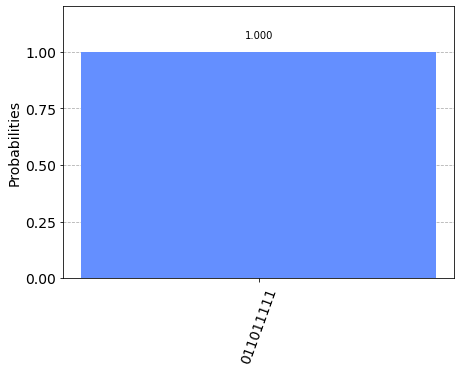

In [8]:
plot_histogram(answer)

### References
- https://www.cs.uni.edu/~wallingf/teaching/cs3530/sessions/session17.html
- https://www.geeksforgeeks.org/decision-trees-fake-coin-puzzle/
- https://arxiv.org/pdf/quant-ph/9705041.pdf
- https://arxiv.org/pdf/1009.0416.pdf